In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore

In [2]:
file_path = "../datos-estadistica/datos.xlsx"
df = pd.read_excel(file_path)

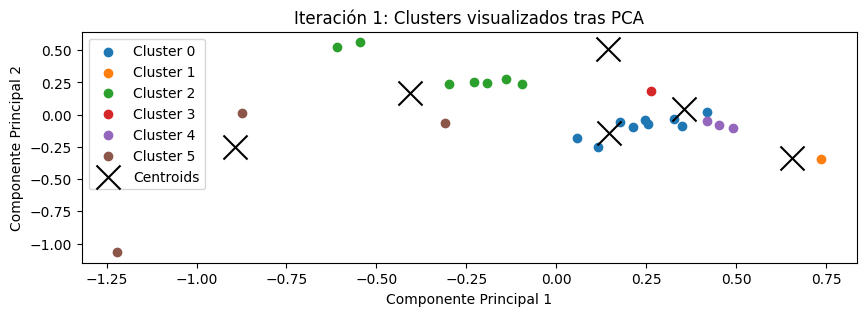

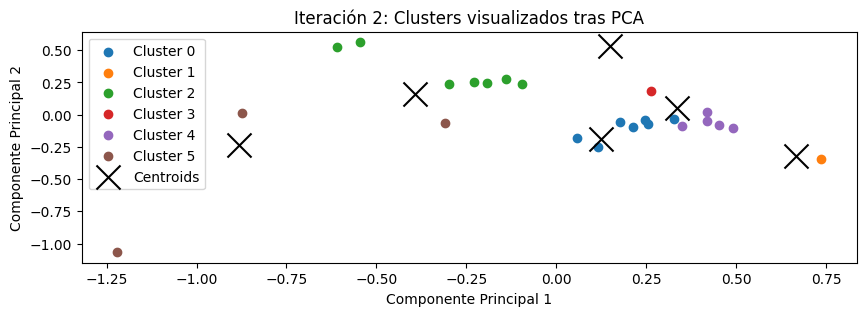

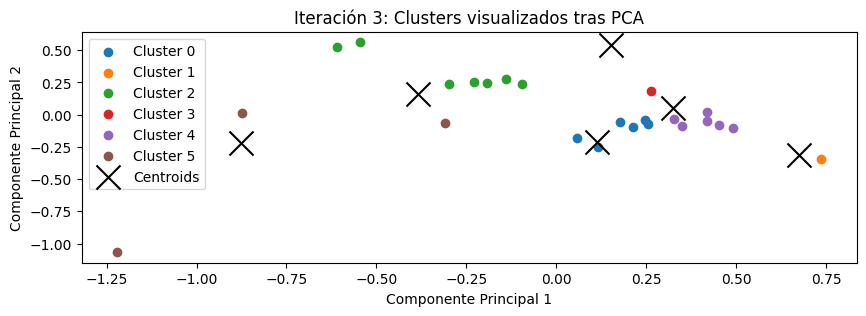

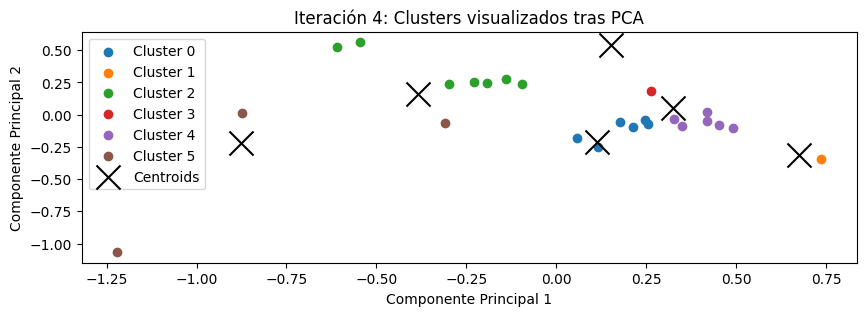

                       ID         label
5      Bucaramanga (test)       Pereira
7           Cúcuta (test)    Valledupar
8           Ibagué (test)       Pereira
26          Arauca (test)  Barranquilla
27           Mocoa (test)        Quibdó
29  Puerto Carreño (test)    San Andrés


C:\Users\Maria Silvia\AppData\Local\Temp\ipykernel_63524\3238117258.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Predicted City'] = closest_cities


In [3]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
from scipy.spatial.distance import cdist # type: ignore


def normalize_data(df, columns_to_normalize):
    min_values = df[columns_to_normalize].min()
    max_values = df[columns_to_normalize].max()
    df_normalized = df.copy()
    df_normalized[columns_to_normalize] = (df[columns_to_normalize] - min_values) / (max_values - min_values)
    return df_normalized

def initialize_centroids_kmeans_plus(X, k):
    n_samples, n_features = X.shape
    centroids = np.empty((k, n_features))
    centroids[0] = X[np.random.choice(n_samples)]
    
    for i in range(1, k):
        distances = np.min([np.linalg.norm(X - centroid, axis=1) for centroid in centroids[:i]], axis=0)
        probabilities = distances / np.sum(distances)
        centroid_idx = np.random.choice(n_samples, p=probabilities)
        centroids[i] = X[centroid_idx]
    
    return centroids

def assign_clusters_cosine(X, centroids):
    # Calcular la distancia coseno entre cada punto y cada centroide
    distances = cdist(X, centroids, metric='cosine')
    
    # Asignar cada punto al centroide más cercano
    cluster_assignments = np.argmin(distances, axis=1)
    
    return cluster_assignments

def update_centroids(X, labels, k):
    # Inicializar una matriz para almacenar los centroides
    centroids = np.zeros((k, X.shape[1]))
    
    # Inicializar un vector para contar el número de puntos en cada cluster
    counts = np.zeros(k)
    
    # Sumar los puntos en cada cluster
    for i in range(k):
        cluster_points = X[labels == i]
        if cluster_points.size > 0:
            centroids[i] = np.sum(cluster_points, axis=0)
            counts[i] = cluster_points.shape[0]
    
    # Dividir la suma de los puntos por el número de puntos en cada cluster
    centroids = np.divide(centroids, counts[:, np.newaxis], where=counts[:, np.newaxis] > 0)
    
    return centroids


def pca(X, n_components=2):
    X_meaned = X - np.mean(X, axis=0)
    cov_matrix = np.cov(X_meaned, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_index = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_index]
    eigenvector_subset = sorted_eigenvectors[:, 0:n_components]
    X_reduced = np.dot(X_meaned, eigenvector_subset)
    return X_reduced

def plot_clusters(X_pca, labels, centroids, iteration):
    plt.figure(figsize=(10, 3))
    
    k = len(np.unique(labels))
    for cluster in range(k):
        cluster_data = X_pca[labels == cluster]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')
    
    # Graficar centroides
    plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='black', marker='x', label='Centroids')
    
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.title(f'Iteración {iteration}: Clusters visualizados tras PCA')
    plt.legend()
    plt.show()

def kmeans(X, k, max_iters=10, tol=1e-3):
    centroids = initialize_centroids_kmeans_plus(X, k)
    
    # Normalizar y reducir a 2D para visualización
    X_pca = pca(X, n_components=2)
    
    for i in range(max_iters):
        labels = assign_clusters_cosine(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        
        # Graficar en cada iteración
        plot_clusters(X_pca, labels, pca(new_centroids, 2), iteration=i + 1)
        
        if np.all(np.abs(centroids  == new_centroids)):
            break
        centroids = new_centroids
    
    return labels, centroids

# ------------------ Ejecución del Algoritmo K-means ------------------


file_path = "../datos-estadistica/datos.xlsx"
df = pd.read_excel(file_path)


# Definir las columnas a normalizar
columns_to_normalize = ['GDP (USD Billion)', 'Population (Millions)', 'Unemployment Rate (%)',
                        'Average Age', 'Women (%)', 'Men (%)', 'Budget (USD Billion)']

# Normalizar los datos
df_normalized = normalize_data(df, columns_to_normalize)

# Separar los datos de entrenamiento y prueba
df_train = df_normalized[~df['City'].str.contains('test')]
df_test = df_normalized[df['City'].str.contains('test')]

X_train = df_train[columns_to_normalize].values
X_test = df_test[columns_to_normalize].values

# Aplicar K-means
k = 6  # Número de clusters
labels, centroids = kmeans(X_train, k)

def predict_nearest_city(X_test, centroids, df_train):
    distances = np.linalg.norm(X_test[:, np.newaxis] - centroids, axis=2)
    cluster_labels = np.argmin(distances, axis=1)
    
    # Asegurarse de que 'Cluster' esté en df_train
    df_train = df_train.copy()
    df_train['Cluster'] = assign_clusters_cosine(df_train[columns_to_normalize].values, centroids)
    
    # Obtener las ciudades más cercanas para cada cluster
    city_mapping = df_train.groupby('Cluster')['City'].first().to_dict()
    closest_cities = np.array([city_mapping[label] for label in cluster_labels])
    
    return closest_cities

# Predecir la ciudad más cercana para cada punto de prueba
closest_cities = predict_nearest_city(X_test, centroids, df_train)

# Crear el archivo CSV con el formato solicitado
df_test['Predicted City'] = closest_cities
submission = df_test[['City', 'Predicted City']].rename(columns={'City': 'ID', 'Predicted City': 'label'})

# Guardar el archivo CSV
submission.to_csv('predicciones.csv', index=False)

# Mostrar resultados
print(submission)

In [5]:
columns_to_normalize = ['GDP (USD Billion)', 'Population (Millions)', 'Unemployment Rate (%)',
                         'Average Age', 'Women (%)', 'Men (%)', 'Budget (USD Billion)']

# Calculamos los mínimos y máximos del DataFrame completo
min_values = df[columns_to_normalize].min()
max_values = df[columns_to_normalize].max()

# Normalizamos todo el DataFrame
df_normalized = df.copy()
df_normalized[columns_to_normalize] = (df[columns_to_normalize] - min_values) / (max_values - min_values)

print("\nDataFrame Normalizado:")
print(df_normalized)


DataFrame Normalizado:
                     City  GDP (USD Billion)  Population (Millions)  \
0                  Bogotá           1.000000               1.000000   
1                Medellín           0.422741               0.357043   
2                    Cali           0.211856               0.309623   
3            Barranquilla           0.157434               0.170153   
4               Cartagena           0.096210               0.142259   
5      Bucaramanga (test)           0.065112               0.079498   
6                 Pereira           0.054422               0.065551   
7           Cúcuta (test)           0.043732               0.104603   
8           Ibagué (test)           0.040816               0.072524   
9             Santa Marta           0.033042               0.071130   
10              Manizales           0.031098               0.058577   
11          Villavicencio           0.028183               0.068340   
12                  Pasto           0.025267         

In [6]:
# Separar los datos de entrenamiento y de prueba
train_data = df_normalized[~df['City'].str.contains('test')]
test_data = df_normalized[df['City'].str.contains('test')]

# Imprimir los datos separados para verificar
print("Datos de Entrenamiento:")
print(train_data)

print("\nDatos de Prueba:")
print(test_data)

Datos de Entrenamiento:
             City  GDP (USD Billion)  Population (Millions)  \
0          Bogotá           1.000000               1.000000   
1        Medellín           0.422741               0.357043   
2            Cali           0.211856               0.309623   
3    Barranquilla           0.157434               0.170153   
4       Cartagena           0.096210               0.142259   
6         Pereira           0.054422               0.065551   
9     Santa Marta           0.033042               0.071130   
10      Manizales           0.031098               0.058577   
11  Villavicencio           0.028183               0.068340   
12          Pasto           0.025267               0.061367   
13       Montería           0.023324               0.066946   
14     Valledupar           0.021380               0.064156   
15          Neiva           0.018465               0.047420   
16        Popayán           0.016521               0.044630   
17        Armenia           0.0

In [ ]:
"""def initialize_centroids(X, k):
    Inicializa los centroides aleatoriamente.
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]"""

In [7]:
def initialize_centroids(X, k):
    """
    Inicializa los centroides de manera que se distribuyan equitativamente entre las muestras.
    
    :param X: numpy array de forma (n_samples, n_features), el conjunto de datos.
    :param k: número total de centroides que deseas inicializar.
    :return: numpy array de centroides inicializados.
    """
    n_samples, n_features = X.shape
    
    # Verificar que k sea menor o igual al número de muestras
    if k > n_samples:
        raise ValueError("El número de centroides no puede ser mayor que el número de muestras.")
    
    # Seleccionar un subconjunto de índices aleatorios para centroides
    indices = np.random.choice(n_samples, k, replace=False)
    centroids = X[indices]
    
    return centroids

In [8]:
def assign_clusters(X, centroids):
    """Asigna cada punto al centroide más cercano."""
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

In [9]:
def update_centroids(X, labels, k):
    """Actualiza los centroides como la media de los puntos en cada clúster."""
    return np.array([X[labels == i].mean(axis=0) for i in range(k)])


In [10]:
def kmeans(X, k, max_iters=300, tol=1e-45):
    centroids = initialize_centroids(X, k)
    
    # Normalizar y reducir a 2D para visualización
   # X_pca = pca(X, n_components=2)
    
    for i in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        
        # Graficar en cada iteración
       # plot_clusters(X_pca, labels, pca(new_centroids, 2), iteration=i + 1)
        
        if np.all(np.abs(centroids - new_centroids) < tol):
            break
        centroids = new_centroids
    
    return labels, centroids

In [11]:
# Convertir los datos en un formato numérico
features = ['GDP (USD Billion)', 'Population (Millions)', 'Unemployment Rate (%)', 'Average Age', 'Women (%)', 'Men (%)', 'Budget (USD Billion)']
X_train = train_data[features].values

C:\Users\Maria Silvia\AppData\Local\Temp\ipykernel_63524\866208955.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Cluster'] = labels



Datos de Entrenamiento con Clústeres:


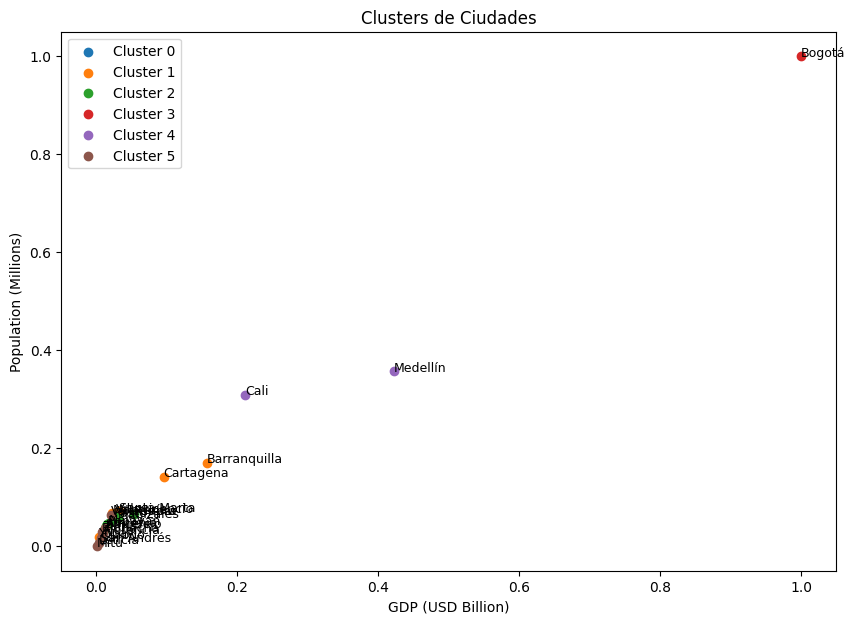

In [12]:
# Determinar el número de clusters (k)
k = 6  # Puedes ajustar esto basado en tu necesidad
labels, centroids = kmeans(X_train, k)

# Añadir etiquetas de clusters a los datos de entrenamiento
train_data['Cluster'] = labels
train_data.to_csv("train_data_with_clusters.csv", index=False)

print("\nDatos de Entrenamiento con Clústeres:")
plt.figure(figsize=(10, 7))

# Graficar cada clúster con un color diferente
for cluster in range(k):
    cluster_data = train_data[train_data['Cluster'] == cluster]
    plt.scatter(cluster_data[features[0]], cluster_data[features[1]], label=f'Cluster {cluster}')

    # Añadir nombres de las ciudades en el gráfico
    for i, city in enumerate(cluster_data['City']):
        plt.text(cluster_data[features[0]].iloc[i], cluster_data[features[1]].iloc[i], city, fontsize=9)

plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title('Clusters de Ciudades')
plt.legend()
plt.show()

#print(train_data)

In [13]:
def predict_clusters(X_test, centroids):
    """Predice el clúster de cada punto de datos en los datos de prueba."""
    return assign_clusters(X_test, centroids)

# Convertir los datos de prueba en un formato numérico
X_test = test_data[features].values

# Predecir los clusters para los datos de prueba
test_labels = predict_clusters(X_test, centroids)

# Añadir las predicciones a los datos de prueba
test_data['Cluster'] = test_labels

# Mapear clusters a ciudades basadas en los datos de entrenamiento
cluster_to_city = train_data.groupby('Cluster')['City'].first().to_dict()
test_data['Predicted_City'] = test_data['Cluster'].map(cluster_to_city)

print("\nDatos de Prueba con Predicciones:")
print(test_data)



Datos de Prueba con Predicciones:
                     City  GDP (USD Billion)  Population (Millions)  \
5      Bucaramanga (test)           0.065112               0.079498   
7           Cúcuta (test)           0.043732               0.104603   
8           Ibagué (test)           0.040816               0.072524   
26          Arauca (test)           0.002915               0.009763   
27           Mocoa (test)           0.001944               0.004184   
29  Puerto Carreño (test)           0.000000               0.000000   

    Unemployment Rate (%)  Average Age  Women (%)   Men (%)  \
5                0.000000     1.000000   0.666667  0.333333   
7                0.554688     0.285714   0.333333  0.666667   
8                0.328125     0.714286   0.666667  0.333333   
26               0.234375     0.428571   0.333333  0.666667   
27               0.453125     0.000000   0.666667  0.333333   
29               1.000000     0.285714   0.000000  1.000000   

    Budget (USD Billion) 

C:\Users\Maria Silvia\AppData\Local\Temp\ipykernel_63524\1705441756.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Cluster'] = test_labels
C:\Users\Maria Silvia\AppData\Local\Temp\ipykernel_63524\1705441756.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_City'] = test_data['Cluster'].map(cluster_to_city)


In [14]:
X_test = test_data[features].values

# Predecir los clusters para los datos de prueba
test_labels = predict_clusters(X_test, centroids)

# Añadir las predicciones a los datos de prueba
test_data['Cluster'] = test_labels

# Mapear clusters a ciudades basadas en los datos de entrenamiento
cluster_to_city = train_data.groupby('Cluster')['City'].first().to_dict()
test_data['Predicted_City'] = test_data['Cluster'].map(cluster_to_city)

# Mostrar los resultados
print("\nDatos de Prueba con Predicciones:")
print(test_data)

# Guardar los resultados en un nuevo archivo CSV
test_data.to_csv('test_data_with_predictions.csv', index=False)


Datos de Prueba con Predicciones:
                     City  GDP (USD Billion)  Population (Millions)  \
5      Bucaramanga (test)           0.065112               0.079498   
7           Cúcuta (test)           0.043732               0.104603   
8           Ibagué (test)           0.040816               0.072524   
26          Arauca (test)           0.002915               0.009763   
27           Mocoa (test)           0.001944               0.004184   
29  Puerto Carreño (test)           0.000000               0.000000   

    Unemployment Rate (%)  Average Age  Women (%)   Men (%)  \
5                0.000000     1.000000   0.666667  0.333333   
7                0.554688     0.285714   0.333333  0.666667   
8                0.328125     0.714286   0.666667  0.333333   
26               0.234375     0.428571   0.333333  0.666667   
27               0.453125     0.000000   0.666667  0.333333   
29               1.000000     0.285714   0.000000  1.000000   

    Budget (USD Billion) 

C:\Users\Maria Silvia\AppData\Local\Temp\ipykernel_63524\2355905382.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Cluster'] = test_labels
C:\Users\Maria Silvia\AppData\Local\Temp\ipykernel_63524\2355905382.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_City'] = test_data['Cluster'].map(cluster_to_city)
